In [1]:
#インポート関連一式
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras.utils import np_utils
import matplotlib.pyplot as plt
import japanize_matplotlib
import warnings
warnings.simplefilter("ignore")

In [8]:
#データクレンジング後のcsv(./comp_files/~~.csv)を順次読み込む

#関数
def select_league(league): # 0: セ・リーグ 1: パ・リーグ
    if league == 0:
        fname_p = f"./comp_files/{year_list[i]}_clg_Pitchers.csv"
        fname_f = f"./comp_files/{year_list[i]}_clg_Fielders.csv"
        return fname_p, fname_f
    elif league == 1:
        fname_p = f"./comp_files/{year_list[i]}_plg_Pitchers.csv"
        fname_f = f"./comp_files/{year_list[i]}_plg_Fielders.csv"
        return fname_p, fname_f
    else:
        print("0 or 1を入力")

#--------------------------------------------------------------------------------------------------------
#main処理
#--------------------------------------------------------------------------------------------------------
#投手用
#col = re_df.columns #Index(['選手名', '球速', 'コントロール', 'スタミナ', '球団', '背番号']
year_list = ["2011", "2012", "2013", "2014", "2016", "2018", "2020", "2022"]
num = len(year_list)
numbering_p_list = []
#リーグ選択  0: セ・リーグ 1: パ・リーグ
league = 0

#year_list分データを読み込み、結合する
for i in range(num):
    fname = select_league(league)
    base_p_df = pd.read_csv(fname[0], encoding="utf-8") #fname[0] 投手 fname[1] 野手
    status = base_p_df.iloc[:,:5]
    team = base_p_df.iloc[:,-2:-1]
    re_p_df = pd.concat([status, team], axis=1)
    re_p_df["ナンバリング"] = year_list[i]
    numbering_p_list.append(re_p_df)
#ナンバリング分のDFを結合
re_p_df = pd.concat(numbering_p_list, ignore_index = True, axis=0)
#球団、ナンバリングでグループ化して、平均化
all_p_df = re_p_df.groupby(["球団","ナンバリング"], as_index=False).mean()
#結合したDFを球団、ナンバリングでソート
sort_p_df = all_p_df.sort_values(["ナンバリング", "球団"])

#野手用
numbering_list_f = []
for i in range(num):
    fname = select_league(league)
    base_f_df = pd.read_csv(fname[1], encoding="utf-8") #fname[0] 投手 fname[1] 野手
    re_f_df = base_f_df.drop("背番号", axis=1)
    re_f_df["ナンバリング"] = year_list[i]
    numbering_list_f.append(re_f_df)
#ナンバリング分のDFを結合
re_f_df = pd.concat(numbering_list_f, ignore_index = True, axis=0)
all_f_df = re_f_df.groupby(["球団","ナンバリング"], as_index=False).mean()
sort_f_df = all_f_df.sort_values(["ナンバリング", "球団"])
sort_f_df = sort_f_df.drop(["球団", "ナンバリング"], axis=1)
#投手、野手を結合する　インデックスでmerge  0 7 14 21 28 indexはmerge後に振りなおす
convert_df = pd.merge(sort_p_df, sort_f_df, how="inner", left_index=True, right_index=True)
convert_df.reset_index(drop=True, inplace=True)

#課題で使用したエクセルデータから勝率などを取得する
base_df = pd.read_excel("2023_baseball.xlsx")
base_df.rename(columns={2009: "球団"}, inplace=True)
#ナンバリングと同じ年数を抽出
rd2011 = base_df[16:22].sort_values("球団") #2011
rd2012 = base_df[24:30].sort_values("球団") #2012
rd2013 = base_df[32:38].sort_values("球団") #2013
rd2014 = base_df[40:46].sort_values("球団") #2014
rd2016 = base_df[56:62].sort_values("球団") #2016
rd2018 = base_df[72:78].sort_values("球団") #2018
rd2020 = base_df[88:94].sort_values("球団") #2020
rd2022 = base_df[104:110].sort_values("球団") #2022
#concatで結合
ex_lis = [rd2011, rd2012, rd2013, rd2014, rd2016, rd2018, rd2020, rd2022]
ex_df = pd.concat(ex_lis, ignore_index=True, axis=0)
ex_col = ex_df.columns  #Index(['球団', '勝率', '勝', '敗', '分', '得点', '失点', '打率', '本塁打', '盗塁', '防御率']
#convert_dfに勝率を追加　行数は同じためそのまま代入
convert_df["勝率"] = ex_df["勝率"]
convert_df["順位"] = ex_df["順位"]
#各年代の各チームでの平均値のcsvを保存する　機械学習、分析用など
if league == 0:
    convert_df.to_csv("DL_PawaClg.csv", encoding="utf-8", index=False)
else:
    convert_df.to_csv("DL_PawaPlg.csv", encoding="utf-8", index=False)
convert_df.iloc[0:37] #行:2020まで
status = convert_df.iloc[0:37, 2:13] #行:2020まで　列:勝率前まで
#外れ値を指定　インデックスを取得
rows = convert_df.loc[[9,15,21,33,28]]
fordrop = convert_df.index[rows.index]
#インデックスのリスト指定でドロップ
convert_df2 = convert_df.drop(fordrop, axis=0)
#2020までのステータスのみ抽出(予測モデルデータ)
status = convert_df2.iloc[:37, 2:13]
#2020までの勝率のみ(予測モデルデータ)
win_rate = convert_df2.iloc[0:37, 13:14] 


#------------------------------------------------------------------------------------------------------------
#Neural Network
#------------------------------------------------------------------------------------------------------------

X_data = status
y_data = win_rate
#train_test_splitで訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=42)
#ndarrayへ変換、float32へ変換
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = X_train.astype("float32")
X_test =  X_test.astype("float32")
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

#予測モデル作成 最小二乗法
model = Sequential()
model.add(Dense(64, input_dim=11, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
# 損失関数にmse、最適化関数にadam
model.compile(loss="mse", optimizer=Adam(), metrics=["mae"])
#予測
history = model.fit(X_train, y_train, epochs=35, batch_size=3, verbose=1, validation_data=(X_test, y_test))
#予測スコア
score = model.evaluate(X_test, y_test, verbose=0)
print(f"evaluate loss: {score[0]}\nevaluate mae: {score[1]}")

Epoch 1/35
9/9 [==============================] - 0s 11ms/step - loss: 31.4292 - mae: 4.0890 - val_loss: 1.7240 - val_mae: 1.3045
Epoch 2/35
9/9 [==============================] - 0s 2ms/step - loss: 4.9741 - mae: 1.8243 - val_loss: 3.8874 - val_mae: 1.9641
Epoch 3/35
9/9 [==============================] - 0s 3ms/step - loss: 5.8658 - mae: 2.1087 - val_loss: 3.1843 - val_mae: 1.7750
Epoch 4/35
9/9 [==============================] - 0s 2ms/step - loss: 6.0537 - mae: 1.9286 - val_loss: 0.9832 - val_mae: 0.9787
Epoch 5/35
9/9 [==============================] - 0s 3ms/step - loss: 5.6317 - mae: 1.8292 - val_loss: 0.3971 - val_mae: 0.6177
Epoch 6/35
9/9 [==============================] - 0s 3ms/step - loss: 3.1471 - mae: 1.3216 - val_loss: 0.1468 - val_mae: 0.3684
Epoch 7/35
9/9 [==============================] - 0s 3ms/step - loss: 1.2322 - mae: 0.8707 - val_loss: 1.0980 - val_mae: 1.0411
Epoch 8/35
9/9 [==============================] - 0s 2ms/step - loss: 1.7531 - mae: 1.0427 - val_loss:

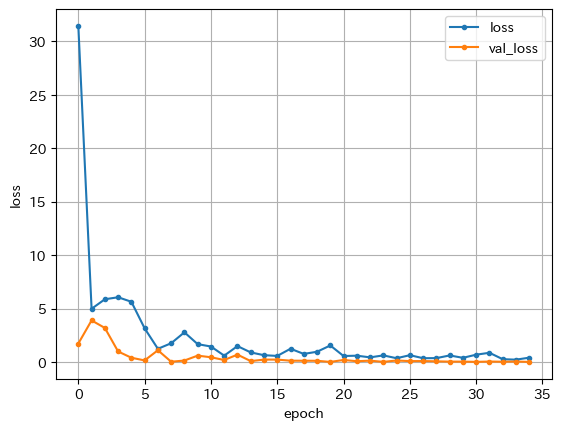

In [9]:
#損失グラフ描画
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
#作成したモデルで順位予想
#2022のステータスを用意
status2022 = convert_df2.iloc[37:, 2:13]
status2022 = np.array(status2022)
status2022 = status2022.astype("float32")
# print(status2022.shape)
predict = model.predict(status2022)
# print(predict)
result = convert_df.iloc[42:,:2] #元のDFからインデックス　ナンバリングを再利用
result["NN予想勝率"] = predict

#結果表示
rank_list = [1,2,3,4,5,6]
rank = result.sort_values("NN予想勝率", ascending=False).round(4)
rank.rename(columns={"ナンバリング": "年度"}, inplace=True)
rank["予想順位"] = rank_list
# display(rank)
rank.to_csv("Predict_NeuralNetwork.csv", encoding="utf-8", index=False)
rank.to_csv("Predict_NeuralNetwork_forWindows.csv", encoding="cp932", index=False)
print("勝率順位予想:Neural_Network")
for i in range(6):
    print("-------------------------------")
    print(f"{rank_list[i]}位: {rank.values[i][0]}:{rank.values[i][2]:.2%}")
print("-------------------------------")

勝率順位予想:Neural_Network
-------------------------------
1位: 巨人:48.55%
-------------------------------
2位: 中日:48.15%
-------------------------------
3位: DeNA:47.04%
-------------------------------
4位: 広島:44.57%
-------------------------------
5位: 阪神:42.95%
-------------------------------
6位: ヤクルト:41.82%
-------------------------------
